Python3 notebook for plotting saturation curves after running `downsample_bam.py`  

`helper_functions.py` from https://github.com/AllonKleinLab/klunctions/blob/master/sam/Analysis/scBasics/helper_functions.py

In [1]:
%matplotlib inline
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
from scipy.stats import pearsonr

sys.path.append('../../scBasics')
import helper_functions as hf

In [2]:
hf.set_plot_defaults(fontsize=12)

#### Load results of `downsample_bam.py`

In [3]:
reads = {} # stores number of mapped reads for each cell barcode, at different downsampling rates
umis = {} # stores number of UMIs for each cell barcode, at different downsampling rates
sample_list = []

data_dir = './example_summary_files' # folder with output of downsample_bam.py

for f in os.listdir(data_dir):
    if f.endswith('read_counts.tsv.gz'):
        s = f.split('.')[0]
        sample_list.append(s)
        reads[s] = pd.read_table(f'{data_dir}/{s}.read_counts.tsv.gz', index_col=0)
        umis[s] = pd.read_table(f'{data_dir}/{s}.umi_counts.tsv.gz', index_col=0)
        
sample_list.sort()

In [4]:
print(sample_list)

['1A1', '1A2', '1B', '1C', '1D', '2A1', '2B', '2C1', '2C2', 'S1', 'S5']


In [5]:
umis[s].head()

,p_0.05,p_0.1,p_0.2,p_0.3,p_0.4,p_0.5,p_0.6,p_0.7,p_0.8,p_0.9,p_1.0
barcode,,,,,,,,,,,
bcDCIA,262,509,980,1394,1833,2251,2660,3036,3388,3731,4043
bcIBNN,754,1503,2859,4191,5388,6636,7736,8842,9878,10900,11855
bcAGFN,207,391,714,1032,1327,1644,1941,2219,2473,2720,2971
bcGIHJ,328,615,1207,1765,2287,2773,3254,3685,4114,4518,4923
bcEFVW,316,611,1168,1653,2141,2597,3050,3442,3821,4209,4563


#### Threshold total counts to call cells vs. background

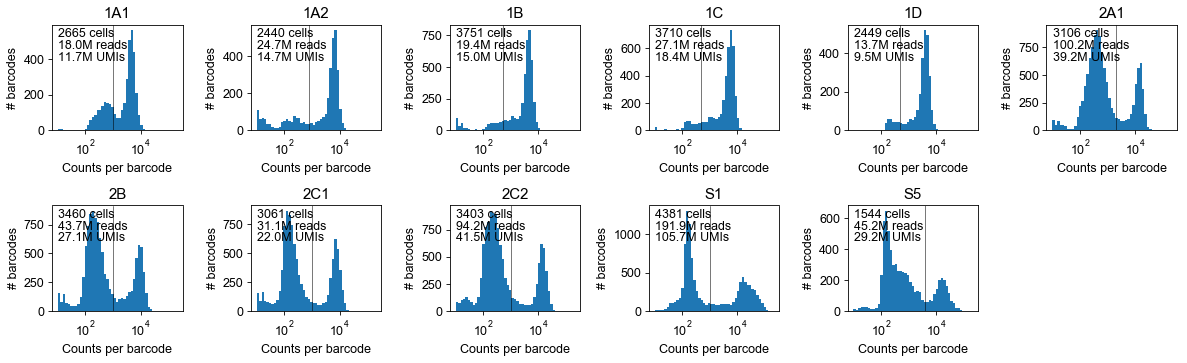

In [6]:
thr_dict = {
    '1A1': 1000,
    '1A2': 800, 
    '1B': 500, 
    '1C': 500, 
    '1D': 500,  
    '2A1': 2000, 
    '2B': 1000, 
    '2C1': 1000, 
    '2C2': 1000, 
    'S1': 1000, 
    'S5': 4000
}

fig, nrow, ncol = hf.start_subplot_figure(len(sample_list), row_height=2.5, dpi=75, n_columns=6, fig_width=16)

for iS,s in enumerate(sample_list):
    umi_thr = thr_dict[s]
    ax = plt.subplot(nrow, ncol, iS+1)
    umi_tots = umis[s]['p_1.0'].values
    read_tots = reads[s]['p_1.0'].values
    mask = umi_tots >= thr_dict[s]
    hf.total_counts_histogram(umi_tots, ax=ax, min_bin=10, max_bin=2e5)
    xl = np.array(ax.get_xlim())
    yl = np.array(ax.get_ylim())
    ax.set_xlim(xl)
    ax.set_ylim(yl)
    ax.plot(umi_thr*np.ones(2), yl, c='black', linewidth=0.5)
    ax.text(xl[0] + np.log10(.05 * xl.ptp()), yl[0] + .88 * yl.ptp(), f'{mask.sum()} cells')
    ax.text(xl[0] + np.log10(.05 * xl.ptp()), yl[0] + .77 * yl.ptp(), f'{read_tots[mask].sum() / 1e6 :.1f}M reads')
    ax.text(xl[0] + np.log10(.05 * xl.ptp()), yl[0] + .66 * yl.ptp(), f'{umi_tots[mask].sum() / 1e6 :.1f}M UMIs')
    
    ax.set_title(s)
    
fig.tight_layout()

#### Average UMIs/cell and reads/cell

In [7]:
print(
    '{:<8s}{:>20s}{:>20s}{:>20s}{:>20s}'.format(
        'library', 'avg reads/cell', 'avg UMIs/cell', 'median reads/cell', 'median UMIs/cell'
    )
)

for iS,s in enumerate(sample_list):
    mask = umis[s]['p_1.0'] > thr_dict[s]
    avg_umi = np.mean(umis[s].loc[mask, 'p_1.0'])
    avg_read = np.mean(reads[s].loc[mask, 'p_1.0'])
    med_umi = np.median(umis[s].loc[mask, 'p_1.0'])
    med_read = np.median(reads[s].loc[mask, 'p_1.0'])
    print(f'{s :<8s}{avg_read :>20.0f}{avg_umi :>20.0f}{med_read :>20.0f}{med_umi :>20.0f}')

library       avg reads/cell       avg UMIs/cell   median reads/cell    median UMIs/cell
1A1                     6739                4407                6581                4304
1A2                    10104                6015                9925                5950
1B                      5186                4007                5272                4082
1C                      7310                4959                7447                5056
1D                      5598                3875                5530                3840
2A1                    32253               12632               32332               12773
2B                     12638                7836               12386                7762
2C1                    10147                7178                9863                6998
2C2                    27696               12194               27868               12388
S1                     43793               24136               31536               17612
S5                   

#### Get min and max x,y values to plot all samples on same scale

In [8]:
max_x = 0
max_y = 0
min_max_x = 1e9
for s in sample_list:
    mask = umis[s]['p_1.0'] > thr_dict[s]
    max_x = max(max_x, np.median(reads[s].loc[mask, 'p_1.0']))
    max_y = max(max_y, np.median(umis[s].loc[mask, 'p_1.0']))
    min_max_x = min(min_max_x, np.median(reads[s].loc[mask, 'p_1.0']))
    
max_x = max_x * 1.05
max_y = max_y * 1.05

### Plot median UMIs/cell vs. median reads/cell - each sample on its own axes

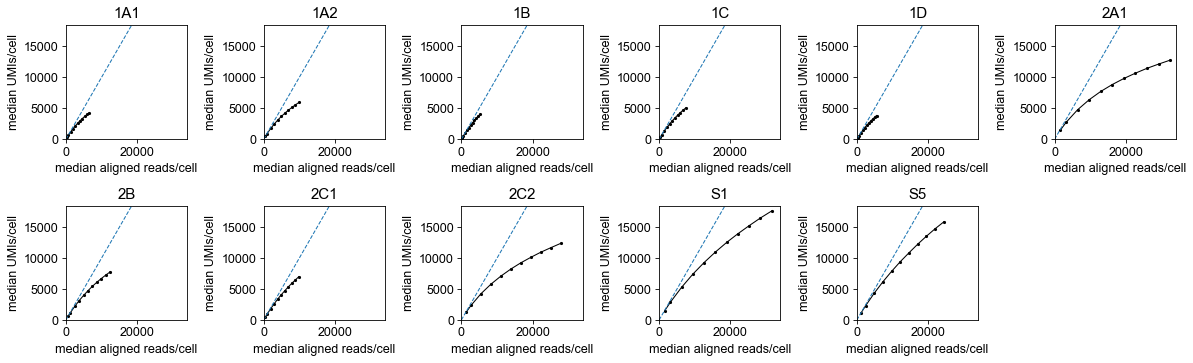

In [9]:
uniform_axis_limits = True


fig, nrow, ncol = hf.start_subplot_figure(len(sample_list), row_height=2.5, dpi=75, n_columns=6, fig_width=16)

all_x = []
all_y = []

for iS,s in enumerate(sample_list):
    ax = plt.subplot(nrow, ncol, iS+1)
    
    umi_tots = umis[s]['p_1.0'].values
    read_tots = reads[s]['p_1.0'].values
    mask = umi_tots >= thr_dict[s]

    x = np.median(reads[s][mask].values, 0)
    y = np.median(umis[s][mask].values, 0)
    ax.plot(x, y, 'o-', markersize=2, c='black', linewidth=1)
    xl = ax.get_xlim()
    yl = ax.get_ylim()
    ax.plot([0,max_y], [0,max_y], '--', linewidth=1)
    
    all_x.append(x)
    all_y.append(y)

    ax.set_title(s)
    
    if uniform_axis_limits:
        ax.set_xlim(0, max_x)
        ax.set_ylim(0, max_y)
    else:
        ax.set_xlim(xl)
        ax.set_ylim(yl)
    ax.set_xlabel('median aligned reads/cell')
    ax.set_ylabel('median UMIs/cell')
    
fig.tight_layout()

all_x = np.array(all_x).T
all_y = np.array(all_y).T


### Plot median UMIs/cell vs. median reads/cell - all samples on same axes

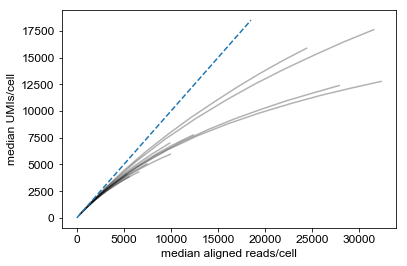

In [10]:
fig,ax = plt.subplots()
ax.plot(all_x, all_y, '-', markersize=3, c='black', alpha=0.3);
ax.plot([0, max_y], [0, max_y], '--')
yl = ax.set_xlabel('median aligned reads/cell')
xl = ax.set_ylabel('median UMIs/cell')


#### Zoom in on the region where we have coverage of all libraries

(250, 5000)

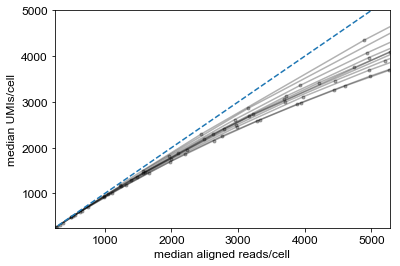

In [11]:
fig,ax = plt.subplots()
ax.plot(all_x, all_y, 'o-', markersize=3, c='black', alpha=0.3);
ax.plot([0, max_y], [0, max_y], '--')
yl = ax.set_xlabel('median aligned reads/cell')
xl = ax.set_ylabel('median UMIs/cell')

ax.set_xlim(250, min_max_x)
ax.set_ylim(250, 5000)


#### Compare avg UMIs/read at a given read depth
We don't actually have the exact same number of reads sampled for every library, so find the closest one to a target depth.

In [12]:
target_depth = 5000

use_ix = np.argmin(np.abs(all_x - target_depth), axis=0)
reads_per_umi = []
reads_per_cell = []

for iS in range(len(use_ix)):
    reads_per_umi.append(all_x[use_ix[iS], iS] / all_y[use_ix[iS], iS] )
    reads_per_cell.append(all_x[use_ix[iS], iS])


print('{:<10s}{:>20s}{:>20s}'.format('library', 'UMIs/read', 'reads/cell'))
for iS,s in enumerate(sample_list):
    print(f'{s :<10s}{reads_per_umi[iS] :>20.2f}{reads_per_cell[iS] :>20.0f}')

library              UMIs/read          reads/cell
1A1                       1.43                5263
1A2                       1.34                4964
1B                        1.26                4744
1C                        1.33                5196
1D                        1.40                4976
2A1                       1.35                6449
2B                        1.25                4957
2C1                       1.21                4930
2C2                       1.30                5556
S1                        1.19                6302
S5                        1.12                4885
